### **Reto Final - Parte 2**

* Integrantes: 
  
  * Rafael J. Mateo C -  A01793054
  * Matthias Sibrian - A01794249
  
* Materia: Ciencia y Analítica de Datos
  
* Profesor: María de la Paz
  
* Fecha: 18 Nov 2022

In [303]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, learning_curve, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")



### **1. Definición de Funciones**

Comencemos definiendo algunas funciones que estaremos usando para el ejercicio. Estas funciones son:

1. plot_learning_curve, la cual usaremos para graficar una curva de aprendizaje que nos permita evaluar si los modelos están subentrenados o sobrenetreandos.
2. print_scores, la cual imprimirá las métricas de la validación cruzada de los modelos.
3. plot_confussion_matrix para graficar la matriz de confusión.

In [304]:
def plot_learning_curve(model, X, y, cv):
    
    sizes = np.linspace(0.1,1.0,20)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator = model, 
        X = X, 
        y = y, 
        cv = cv,
        scoring='accuracy', 
        train_sizes = sizes)
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    
    plt.plot(train_sizes, train_mean, color = 'tab:red', marker='o', label= 'Entrenamiento')
    plt.fill_between(
        train_sizes, 
        train_mean + train_std,
        train_mean - train_std, alpha = 0.1, color = 'tab:red')
    
    plt.plot(train_sizes, test_mean, color = 'tab:green', marker='+', label = 'Validación' )
    plt.fill_between(
        train_sizes, test_mean + test_std, 
        test_mean - test_std, alpha = 0.1, color = 'tab:green')
    
    plt.title('Curva de Aprendizaje')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Exactitud')
    plt.legend(loc='lower right')
    
def print_scores (scores):
    
    avg_train = np.round(np.mean(scores['train_score']), 2)
    std_train = np.round(np.std(scores['train_score']),2)
    avg_test = np.round(np.mean(scores['test_score']),2)
    std_test = np.round(np.std(scores['test_score']),2)
    
    print(f'Métrica exactitud para conjunto de entrenamiento: {avg_train} ({std_train})')
    print(f'Métrica exactitud para conjunto de validación: {avg_test} ({std_test})')
    

def plot_confussion_matrix(y_real, y_pred, classes):
    cm_dt = confusion_matrix(y_real, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt,
                            display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

### **2. Importación de los Datos** 

Ahora realicemos la importación de los datos

In [305]:
df = pd.read_csv('datos/aguas_subterraneas_2020.csv')
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CA�ADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


En el ejercicio anterior habíamos concluido que estaríamos usando las variables numéricas en lugar de las binarias y categóricas para los atributos químicos, a excepción del "Cadmio", ya que solo tienen 3 datos únicos y por tanto cuenta con casi la misma informaicón que la binaria.

También concluimos eliminar la variable "SDT_mg/L", puesto que la columna está completamente vacía, además que es un atributo que puede ser estimado a partir de la conductividad, por lo que ambas tendrían una correlación alta.

Por último, también se eliminan aquellas variables con una correlación mayor o igual a 0.75, como el caso del hierro, manganeso y mercurio. Por tanto, nos estaremos quedando solamente con la variable del hierro.

In [306]:
cols_to_drop  = df.columns[df.columns.str.contains('(?!CUMPLE_CON_CD)(?:CALIDAD|CUMPLE)')].to_list()
cols_to_drop.extend(['CLAVE', 'SITIO', 'CONTAMINANTES', 'ORGANISMO_DE_CUENCA', 'PERIODO',
                     'CD_TOT_mg/L', 'ACUIFERO', 'SDT_mg/L', 'LONGITUD', 'LATITUD' , 'HG_TOT_mg/L', 'MN_TOT_mg/L'])

Definimos nuestras X y y

In [307]:

X = df.drop(cols_to_drop + ['SEMAFORO'], axis = 1)

In [308]:
X.head()

,ESTADO,MUNICIPIO,SUBTIPO,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CR_TOT_mg/L,PB_TOT_mg/L,FE_TOT_mg/L,CUMPLE_CON_CD
0,AGUASCALIENTES,ASIENTOS,POZO,229.990,940.0,603.6,0.9766,213.732,<1.1,4.184656,0.0161,<0.005,<0.005,0.0891,SI
1,AGUASCALIENTES,AGUASCALIENTES,POZO,231.990,608.0,445.4,0.9298,185.0514,<1.1,5.75011,0.0134,<0.005,<0.005,<0.025,SI
2,AGUASCALIENTES,COSIO,POZO,204.920,532.0,342,1.8045,120.719,<1.1,1.449803,0.037,<0.005,<0.005,<0.025,SI
3,AGUASCALIENTES,RINCON DE ROMOS,POZO,327.000,686.0,478.6,1.1229,199.879,<1.1,1.258597,0.0154,0.005,<0.005,<0.025,SI
4,BAJA CALIFORNIA SUR,LA PAZ,POZO,309.885,1841.0,1179,0.2343,476.9872,291,15.672251,<0.01,<0.005,<0.005,<0.025,SI


Ahora revisemos la variable de respuesta y si se encuentran balanceadas.

In [309]:
y = df[['SEMAFORO']]

In [310]:
y.head()

,SEMAFORO
0,Verde
1,Verde
2,Rojo
3,Verde
4,Rojo


In [311]:
(y.value_counts()/len(y))*100

SEMAFORO
Verde       40.636704
Rojo        36.235955
Amarillo    23.127341
dtype: float64

Se observa que la clase "Amarillo" se encuentra subrepresentada. Más adelante tomaremos algunas medidas para mitigar el impacto que pueda tener este desbalanceo.

### **3. Imputación de los Datos**

Ahora clasificamos cada columna por su tipo de dato

In [312]:
bin_vars =  ['CUMPLE_CON_CD']
cat_vars = ['SUBTIPO', 'ESTADO', 'MUNICIPIO']
num_vars = X.drop(cat_vars + bin_vars, axis = 1).columns.to_list()

print(f'Numeric variables: {num_vars}\n')
print(f'Categorical variables: {cat_vars}\n')
print(f'Binary variables: {bin_vars}')

Numeric variables: ['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CR_TOT_mg/L', 'PB_TOT_mg/L', 'FE_TOT_mg/L']

Categorical variables: ['SUBTIPO', 'ESTADO', 'MUNICIPIO']

Binary variables: ['CUMPLE_CON_CD']


Definimos un imputador customizado para tratar los valores tipo 'string' que se encuentran en las columnas numéricas. La técnica usada en este ejercicio es la misma que se usó para la parte 1 del reto.

In [313]:
class TextToNumImputer(BaseEstimator, TransformerMixin):
    
    
    def get_text_values(self, df):
        vars = [
        'ALC_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L', 'FE_TOT_mg/L', 'SDT_M_mg/L',
        'SDT_mg/L', 'FLUORUROS_mg/L', 'COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 
        'CR_TOT_mg/L', 'DUR_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L' ]

        limits = {}
        for  var in vars:
                if  (var in df.columns and df[var].dtypes == 'object'):
                        #Obtenemos las observaciones que solo tengan < > o =
                        val_count = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts()
                        if (len(val_count) == 0):
                            continue
                        limits[var] = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts().index
        #Lo convertimos en DF para mejor visualización
        return pd.DataFrame(limits, index = [0])
    
    def extract_values(self, df):
        #Extraemos las columnas que deben ser convertidas de object a float
        limits_df = self.get_text_values(df)

        #Hacemos un transpose para que la tabla tenga dos columnas, una con los atributos químicos y otra con sus valores
        limits_df = limits_df.transpose()
        limits_df = limits_df.reset_index(level = 0)
        limits_df.rename(columns={'index': 'attributes', 0:'attr_values'}, inplace= True)

        #Extraemos los valores numéricos, eliminando cualquier string (por ej. '<')
        limits_df.attr_values = limits_df.attr_values.str.extract('(\d+\.\d+|\d+)')

        return limits_df
   
    def replace_text(self, df):
        
        limits_df = self.extract_values(df)
                
        for col in limits_df.attributes:
            val =  (limits_df.loc[limits_df.attributes == col].attr_values.values[0])
            str_match = '<'+ val
            val = float(val)

            df.loc[df[col] == str_match, col] = val -(val/10)
            
            #Convertimos la columna a tipo float
            df[col] = df[col].astype(float)
            
        return df
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        
        return self.replace_text(X)

Ahora definimos los pipes para cada uno de los tipos de variables que usaremos.

In [314]:
cat_pipeline = Pipeline(steps = [
    ('cat-imp-mode', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary',handle_unknown = 'ignore', sparse=False))
    ])
bin_pipeline = Pipeline(steps = [
    ('bin-imp-mode', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary',handle_unknown = 'ignore', sparse=False))
    ])
num_pipeline = Pipeline(steps = [
    ('text-imputer', TextToNumImputer()),
    ('imp-median', SimpleImputer(strategy='median'))])

preprocessor = ColumnTransformer(transformers = [
    ('bin-imp', bin_pipeline, bin_vars),
    ('catimp', cat_pipeline, cat_vars),
    ('custom-imp', num_pipeline, (num_vars)),
   ],
    remainder='passthrough')
			


Realizamos el label encoding de la variable de respuesta

In [315]:
label_encoder = LabelEncoder()
label_encoder.fit_transform(y)

array([2, 2, 1, ..., 1, 2, 2])

### **4. Entrenamiento de los Modelos**

Ahora comenzaremos a entrenar los siguientes modelos, para seleccionar el que mejor se desempeñe con base a la métrica 'accuracy' o exactitud.

1. Decision Tree
2. Random Forest

Antes de entrenar los modelos, definamos los sets de entrenamiento y prueba, así como el kfold para realizar la validación cruzada.

Para realizar la partición en conjunto de entrenamiento y prueba, nos estaremos apoyando del argumento 'stratify' de la función train_test_split, de manera que nos ayude a tener un conjunto de datos equilibrado.

Con relacióna la validación cruzada, esta nos permitirá evaluar si el modelo está subentrenado o sobrenetrenado, realizando una partición del conjunto de entrenamiento en dos grupos: Conjuntos de entrenamiento y conjuntos de validación.

Por úlitmo, estaremos haciendo uso de la función permutation_importance de sklearn para calcular la importancia de los features. Esto se debe a que el atributo 'features_importance' de los modelos de bosque aleatorio de árbol de decisión son calculados con base en el conjunto de entrenamiento, por lo que pueden dar valores muy altos para variables que no son predictoras de la variable de respuesta.

In [316]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y.values.ravel(), random_state=42)
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

#### **4.1. Decision Tree**

El primer modelo que entrenaremos es el decision tree. Para ello, definiremos un pipeline que contenga tanto la imputación como el modelo a usar.

In [317]:
tree = DecisionTreeClassifier()
pipeline_DT = Pipeline(steps=[('ct', preprocessor), ('m', tree)])

#Obtenemos las métricas de la validación cruzada
scores = cross_validate(
    pipeline_DT, X_train, y_train, 
    cv = kfold, 
    return_train_score= True,
    scoring = 'accuracy')

print_scores(scores)

Métrica exactitud para conjunto de entrenamiento: 1.0 (0.0)
Métrica exactitud para conjunto de validación: 0.94 (0.02)


Ahora generemos una curva de aprendizaje para determinar el comportamiento de este modelo.

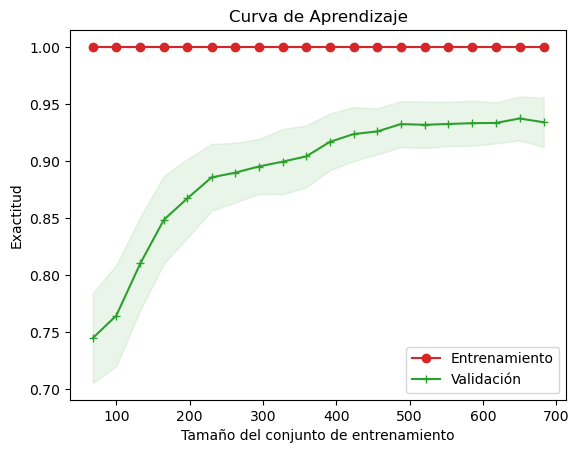

In [318]:
plot_learning_curve(pipeline_DT, X_train, y_train, kfold)

De la curva anterior se puede observar que el modelo está sobreentrenado, debido a la brecha existente ente los datos de entrenamiento y los datos de validación.

Sin embargo, también puede evidenciarse que la brecha disminuye a medida que aumenta el tamaño del conjunto de entrenamiento, por lo que una mayor cantidad de observaciones podría ayudar a disminuir la variación.

Por otro lado, no se observa subentrenamiento, puesto que el sesgo es bajo (la diferencia entre el valor deseado (1.0) y el valor obtenido (0.94)).

Busquemos ahora los valores de los hiperparámetros que optimizan el modelo. Cabe destacar que nos limitaremos a probar solo unas cuantas configuraciones, ya que esto aumenta el tiempo de procesamiento.

In [319]:
params = {
    'm__max_depth': [1,10,100],
    'm__min_samples_split': [2,4,8],
    'm__min_samples_leaf': [1,10],
    'm__ccp_alpha': [0.0001, 0.001, 1],
    'm__class_weight': [None, 'balanced']
    }

grid = GridSearchCV(
    pipeline_DT, 
    cv = kfold,
    param_grid=params, 
    scoring='accuracy')

grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)


0.9428551771585829
{'m__ccp_alpha': 0.001, 'm__class_weight': None, 'm__max_depth': 10, 'm__min_samples_leaf': 1, 'm__min_samples_split': 8}


El valor óptimo de la exactitud con los mejores hiperparámetros encontrados es de .94. Ahora revisemos la curva de aprendizaje para este modelo.

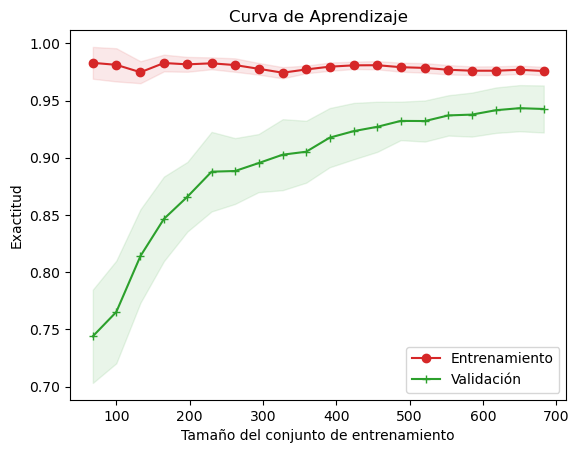

In [320]:
plot_learning_curve(grid.best_estimator_, X_train, y_train, kfold)

Podemos apreciar que la varianza disminuyó, por lo que este modelo está menos sobreentrenado que el que vimos primero. Ahora revisemos la importancia de las variables para la clasificación.

Feature: ESTADO, Score: 0.00000
Feature: MUNICIPIO, Score: 0.00000
Feature: SUBTIPO, Score: 0.00000
Feature: ALC_mg/L, Score: 0.05000
Feature: CONDUCT_mS/cm, Score: 0.00000
Feature: SDT_M_mg/L, Score: 0.05561
Feature: FLUORUROS_mg/L, Score: 0.17991
Feature: DUR_mg/L, Score: 0.11589
Feature: COLI_FEC_NMP/100_mL, Score: 0.09860
Feature: N_NO3_mg/L, Score: 0.09720
Feature: AS_TOT_mg/L, Score: 0.07150
Feature: CR_TOT_mg/L, Score: 0.00794
Feature: PB_TOT_mg/L, Score: 0.01028
Feature: FE_TOT_mg/L, Score: 0.07383
Feature: CUMPLE_CON_CD, Score: 0.00000


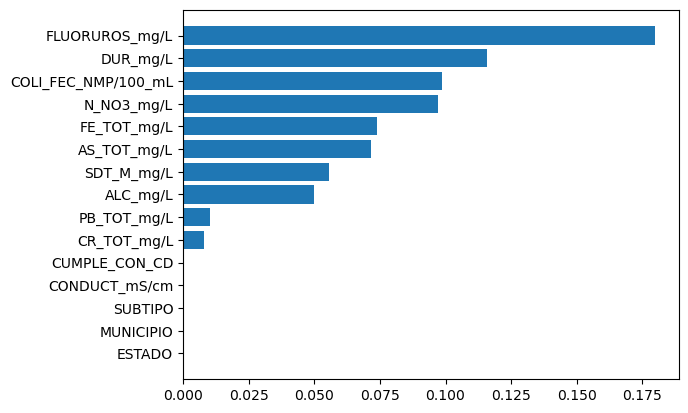

In [321]:

importance = permutation_importance(grid.best_estimator_, X_test, y_test.values.ravel(), n_repeats=10,random_state=42)
for i,v in enumerate(importance['importances_mean']):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))

sorted_indexes = np.argsort(importance['importances_mean'])

plt.barh(X.columns.to_numpy()[sorted_indexes], importance['importances_mean'][sorted_indexes])
plt.show()

Las dos variables que más impactaron en la clasificación fueron dureza y fluoruros.

Otro aspecto relevante del gráfico es que las variables categóricas y binarias tuvieron un efecto nulo en los resultados de la clasificación, teniendo mayor peso las variables numéricas.

Ahora veamos los resultados de las métricas.

In [322]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_hat = best_model.predict(X_test)

In [323]:
print(classification_report(
    y_test, 
    y_hat,
    target_names=best_model.named_steps['m'].classes_))

              precision    recall  f1-score   support

    Amarillo       0.91      0.86      0.88        49
        Rojo       0.96      0.94      0.95        78
       Verde       0.92      0.98      0.95        87

    accuracy                           0.93       214
   macro avg       0.93      0.92      0.93       214
weighted avg       0.93      0.93      0.93       214



De las métricas presentadas arriba, la clase 'Amarillo' es la que tuvo peor desempeño. Es de esperarse, puesto que esta era la clase menor representada en todo el conjunto de datos. Técnicas de balanceo podrían ayudar a mejorar estas métricas.

Ahora revisemos la matriz de confusión.

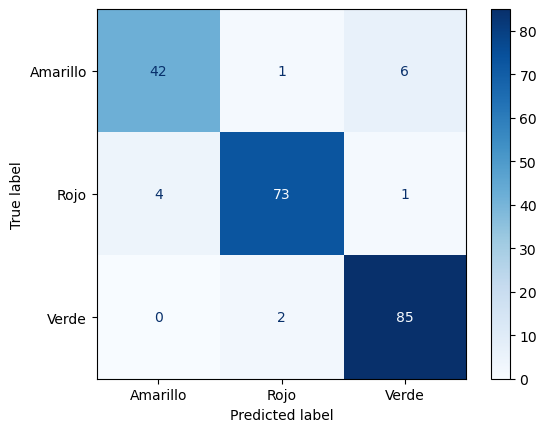

In [324]:
plot_confussion_matrix(y_test, y_hat, best_model.named_steps['m'].classes_)

De la matriz se puede observar que 10 pozos fueron clasificados incorrectamente, siendo la clase 'Amarillo' la que tuvo un mayor número de clasificaciones incorrectas, aunque no por mucho.

Ahora hagamos el análisis para el modelo Random Forest.

#### **4.2. Random Forest**

Preparemos el pipe para el modelo Random Forest y obtengamos las métricas de la validación cruzada.

In [325]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

tree = RandomForestClassifier(random_state=42,
                              criterion='gini')

pipeline_RF = Pipeline(steps=[('ct', preprocessor), ('m', tree)])

scores = cross_validate(
    pipeline_RF, X_train, y_train, 
    cv = kfold, 
    return_train_score= True,
    scoring = 'accuracy')

print_scores(scores)


Métrica exactitud para conjunto de entrenamiento: 1.0 (0.0)
Métrica exactitud para conjunto de validación: 0.92 (0.02)


De la validación cruzada podemos ver que también se encuentra sobre entrenado, con una exactitud promedio de 0.92 (menor que el modelo de árbol de decisión).

Revisemos ahora la curva de aprendizaje.

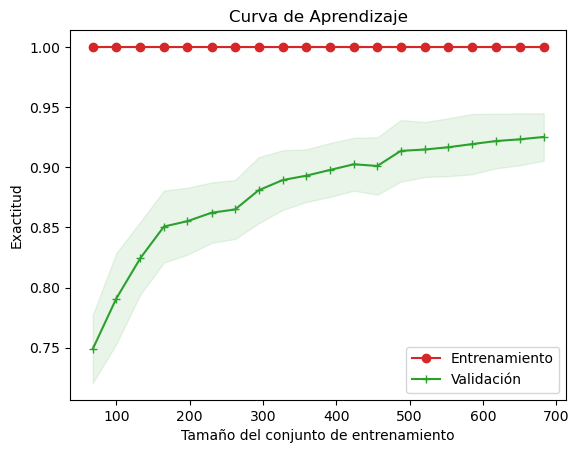

In [326]:
plot_learning_curve(pipeline_RF, X_train, y_train, kfold)

De la curva se concluye la existencia de sobreentrenamiento del modelo, y que mejora a un menor grado que el árbol de decisión a medida que el tamaño del conjunto de entrenamiento aumenta.

Ahora busquemos los parámetros que optimizan el modelo, recordando que solo probaremos un número limitado de combinaciones para minimizar el tiempo de procesamiento.

In [327]:
params = {
    'm__n_estimators': [100,200],
    'm__min_samples_split': [2,4],
    'm__min_samples_leaf': [1,10],
    'm__ccp_alpha': [0.0001, 0.001, 1],
    'm__class_weight': ['balanced', 'balanced_subsample', None]
    }

grid = GridSearchCV(
    pipeline_RF, 
    cv = kfold,
    param_grid=params, 
    scoring='accuracy')

grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9278637770897834
{'m__ccp_alpha': 0.0001, 'm__class_weight': None, 'm__min_samples_leaf': 1, 'm__min_samples_split': 2, 'm__n_estimators': 200}


La mejor métrica obtenida fue de 0.93 aproximadamente, por lo que no mejora lo suficiente, en comparación con el árbol de decisión.

Revisemos la curva de aprendizaje del modelo óptimo.

In [328]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train.values.ravel())
y_hat_rf = best_model.predict(X_test)

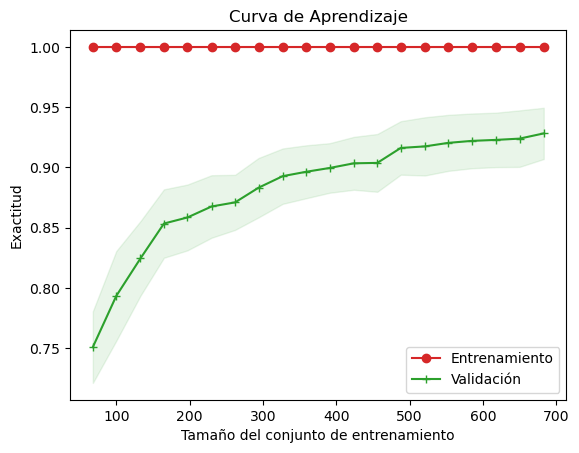

In [329]:
plot_learning_curve(best_model, X_train, y_train, kfold)

Tiene un comportamiento muy similar al modelo original, por lo que no se aprecia una mejora significativa al utilizar los parámetros óptimos. Veamos la importancia de las variables.

Feature: ESTADO, Score: -0.01121
Feature: MUNICIPIO, Score: -0.00187
Feature: SUBTIPO, Score: 0.00047
Feature: ALC_mg/L, Score: 0.01168
Feature: CONDUCT_mS/cm, Score: 0.00327
Feature: SDT_M_mg/L, Score: 0.00888
Feature: FLUORUROS_mg/L, Score: 0.15421
Feature: DUR_mg/L, Score: 0.09626
Feature: COLI_FEC_NMP/100_mL, Score: 0.08645
Feature: N_NO3_mg/L, Score: 0.08411
Feature: AS_TOT_mg/L, Score: 0.06028
Feature: CR_TOT_mg/L, Score: 0.00047
Feature: PB_TOT_mg/L, Score: 0.00981
Feature: FE_TOT_mg/L, Score: 0.07196
Feature: CUMPLE_CON_CD, Score: 0.00000


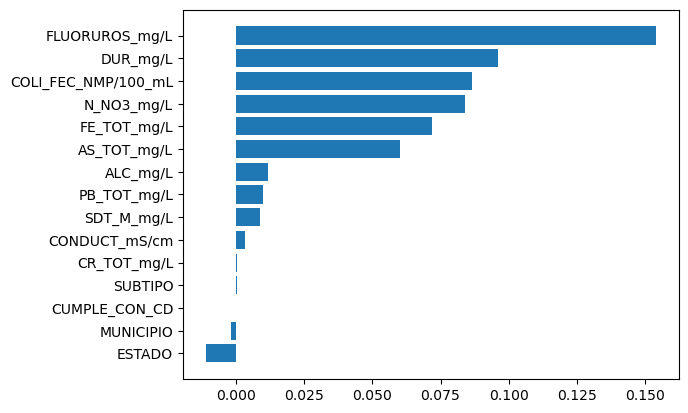

In [330]:
importance = permutation_importance(
    best_model, X_test, 
    y_test.values.ravel(), n_repeats=10,random_state=42)

for i,v in enumerate(importance['importances_mean']):
	print('Feature: %s, Score: %.5f' % (X.columns[i],v))

#Organizamos los índices para realizar el gráfico con los valores de menor a mayor
sorted_indexes = np.argsort(importance['importances_mean'])

plt.barh(X.columns.to_numpy()[sorted_indexes], importance['importances_mean'][sorted_indexes])
plt.show()

Para este modelo, se observa que Dureza y Fluoruros siguen siendo las variables más importante para la clasificación, aunque a diferencia de Árboles de Decisión, las importancias están más distribuidas entre las variables.

reivisemos la matriz de confusión.

In [331]:
print(classification_report(
    y_test, 
    y_hat_rf, 
    target_names=best_model.named_steps['m'].classes_))

              precision    recall  f1-score   support

    Amarillo       0.84      0.84      0.84        49
        Rojo       0.92      0.92      0.92        78
       Verde       0.92      0.92      0.92        87

    accuracy                           0.90       214
   macro avg       0.89      0.89      0.89       214
weighted avg       0.90      0.90      0.90       214



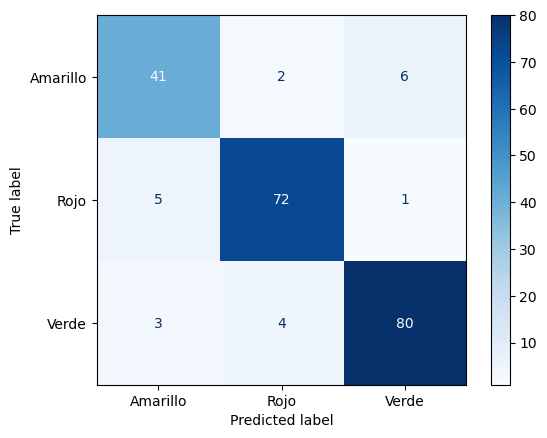

In [332]:
plot_confussion_matrix(y_test, y_hat_rf, best_model.named_steps['m'].classes_)


De la tabla anterior se puede apreciar que la clase amarillo fue la que más tuvo clasificaciones incorrectas, incluso en mayor medida que en el modelo de árbol de decisión. De la matriz de confusión se observan 21 clasificaciones incorrectas para este modelo.

### **5. Conclusión**

El mejor modelo es el árbol de decisión, ya que presenta menos sobreentrenamiento que el modelo de bosque aleatorio, además de que posee una exactitud ligeramente superior.

También se observa que la clase con mayor número de clasificaciones incorrectas es la amarilla. Esto se debe a que es la clase que está subrepreentada en comparación con las demás.

Entre las variables de mayor importancia para las predicciones del modelo están la dureza y fluoruros.